<center>

![Workflow Diagram](WorkFlow_Updated.jpg)

</center>

# Quantum Learning Procedure

In [11]:
import sys
from pathlib import Path
qml_path = (Path.cwd() / "../../QML").resolve()
sys.path.insert(0, str(qml_path))

from Qsun.Qkernels import *
from Qsun.Qgates import *
from Qsun.Qmeas import *
from Qsun.Qcircuit import *
from Qsun.Qwave import *
from Qsun.Qencodes import *
from Qsun.Qdata import *

import numpy as np
import matplotlib.pyplot as plt
from src.load_datasets import *
from src.kernel_evaluation import *
from tqdm import tqdm
from typing import Dict, Tuple, Callable, List
from itertools import combinations
import problexity as px

np.random.seed(1234)

### Loading 9 ansatzes from Qencodes.py

In [12]:
ENCODING_REGISTER = {
    "YZ_CX": {
        "fn": YZ_CX_encode,
        "has_params": True,
        "has_layers": True,
    },
    "HighDim": {
        "fn": HighDim_encode,
        "has_params": False,
        "has_layers": False,
    },
    "HZY_CZ": {
        "fn": HZY_CZ_encode,
        "has_params": True,
        "has_layers": True,
    },
    "Chebyshev": {
        "fn": Chebyshev_encode,
        "has_params": True,
        "has_layers": True,
    },
    "ParamZFeatureMap": {
        "fn": ParamZFeatureMap_encode,
        "has_params": True,
        "has_layers": True,
    },
    "SeparableRX": {
        "fn": SeparableRXEncoding_encode,
        "has_params": False,
        "has_layers": False,
    },
    "HardwareEfficientRx": {
        "fn": HardwareEfficientEmbeddingRx_encode,
        "has_params": False,
        "has_layers": True,
    },
    "ZFeatureMap": {
        "fn": ZFeatureMap_encode,
        "has_params": False,
        "has_layers": True,
    },
    "ZZFeatureMap": {
        "fn": ZZFeatureMap_encode,
        "has_params": False,
        "has_layers": True,
    },
}

def encode_sample(sample, encoding_name, n_layers=2, 
                  params=None):
    if encoding_name not in ENCODING_REGISTER:
        raise ValueError(f"Unknown encoding: {encoding_name}")
    config = ENCODING_REGISTER[encoding_name]
    fn = config["fn"]
    if encoding_name == "YZ_CX":
        return fn(sample, params=params, n_layers=n_layers)
    elif encoding_name == "HZY_CZ":
        return fn(sample, params=params, n_layers=n_layers)
    elif encoding_name == "Chebyshev":
        return fn(sample, params=params, n_layers=n_layers)
    elif encoding_name == "ParamZFeatureMap":
        return fn(sample, params=params, n_layers=n_layers)
    elif encoding_name == "HardwareEfficientRx":
        return fn(sample, n_layers=n_layers)
    elif encoding_name == "ZFeatureMap":
        return fn(sample, n_layers=n_layers)
    elif encoding_name == "ZZFeatureMap":
        return fn(sample, n_layers=n_layers)
    elif encoding_name == "HighDim":
        return fn(sample)
    elif encoding_name == "SeparableRX":
        return fn(sample)
    else:
        raise ValueError(f"Unknown encoding: {encoding_name}")

### Quantum Embedding Kernels

In [13]:
def kernel_matrix(X_train, X_test,
                encoding_name, n_layers=2,
                params=None, random_state=42):
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    encoded_train = []
    for i in range(n_train):
        state = encode_sample(X_train[i], encoding_name, n_layers, params)
        encoded_train.append(state)
    encoded_test = []
    for i in range(n_test):
        state = encode_sample(X_test[i], encoding_name, n_layers, params)
        encoded_test.append(state)
    K_train = np.zeros((n_train, n_train))
    for i in range(n_train):
        for j in range(i, n_train):
            k_ij = state_product(encoded_train[i], encoded_train[j])**2
            K_train[i, j] = k_ij
            K_train[j, i] = k_ij
    K_test = np.zeros((n_test, n_train))
    for i in range(n_test):
        for j in range(n_train):
            K_test[i, j] = state_product(encoded_test[i], encoded_train[j])**2
    
    return K_train, K_test

def total_kernels(X_train, X_test,
                encoding_names=None, n_layers=2,
                random_state=42):
    if encoding_names is None:
        encoding_names = list(ENCODING_REGISTER.keys())
    results = {}
    for name in encoding_names:
        try:
            K_train, K_test = kernel_matrix(
                X_train, X_test, name, n_layers, 
                random_state=random_state)
            results[name] = (K_train, K_test)
        except Exception as e:
                print(f"  Error: {e}")
    
    return results

def get_available_encodings():
    return list(ENCODING_REGISTER.keys())

In [14]:
datasets = load_datasets(
    data_dir="datasets", 
    max_qubit=4, 
    include_variants=True 
)

X_train, X_test, y_train, y_test = datasets["Iris"]

print(f"\nIris dataset: Train {X_train.shape}, Test {X_test.shape}")
print(f"Available encodings: {get_available_encodings()}")

print("Sample encoding: ZFeatureMap")

K_train, K_test = kernel_matrix(
        X_train, X_test, "ZFeatureMap", n_layers=2)



Iris dataset: Train (80, 4), Test (20, 4)
Available encodings: ['YZ_CX', 'HighDim', 'HZY_CZ', 'Chebyshev', 'ParamZFeatureMap', 'SeparableRX', 'HardwareEfficientRx', 'ZFeatureMap', 'ZZFeatureMap']
Sample encoding: ZFeatureMap


In [15]:
datasets = load_datasets(
    data_dir="datasets", 
    max_qubit=4, 
    include_variants=True  
)
for name, (X_tr, X_te, y_tr, y_te) in datasets.items():
    print(f"\n{name} dataset: Train {X_tr.shape}, Test {X_te.shape}")



Blobs_F2C2 dataset: Train (160, 2), Test (40, 2)

Blobs_F2C3 dataset: Train (160, 2), Test (40, 2)

Blobs_F2C4 dataset: Train (160, 2), Test (40, 2)

Blobs_F4C2 dataset: Train (160, 4), Test (40, 4)

Blobs_F4C3 dataset: Train (160, 4), Test (40, 4)

Blobs_F4C4 dataset: Train (160, 4), Test (40, 4)

Blobs_F2C2_std3 dataset: Train (160, 2), Test (40, 2)

Blobs_F2C2_std10 dataset: Train (160, 2), Test (40, 2)

Blobs_F4C2_std3 dataset: Train (160, 4), Test (40, 4)

Blobs_F4C2_std10 dataset: Train (160, 4), Test (40, 4)

Circle_n05_f5 dataset: Train (160, 2), Test (40, 2)

Circle_n10_f5 dataset: Train (160, 2), Test (40, 2)

Circle_n15_f5 dataset: Train (160, 2), Test (40, 2)

Circle_n10_f3 dataset: Train (160, 2), Test (40, 2)

Circle_n10_f8 dataset: Train (160, 2), Test (40, 2)

Moons_n05 dataset: Train (160, 2), Test (40, 2)

Moons_n10 dataset: Train (160, 2), Test (40, 2)

Moons_n15 dataset: Train (160, 2), Test (40, 2)

Moons_n25 dataset: Train (160, 2), Test (40, 2)

XOR dataset: Tra

### Model Execution

In [16]:
def total_runs(dataset_name="Iris", 
               encodings=None,
               n_layers=2,
               n_runs=10,
               test_size=0.2,
               random_state=42,
               include_variants=True):
    if encodings is None:
        encodings = get_available_encodings()
    print(f"Dataset: {dataset_name}")    
    
    results_accumulator = {enc: {m: {"train": [], "test": []} 
                                  for m in ["SVM"]} 
                           for enc in encodings}
    
    for run in tqdm(range(n_runs)):
        seed = random_state + run
        datasets = load_datasets(
            data_dir="datasets",
            random_state=seed, 
            test_size=test_size, 
            max_qubit=4,
            include_variants=include_variants
        )
        X_train, X_test, y_train, y_test = datasets[dataset_name]
        kernels = total_kernels(X_train, X_test, encodings, n_layers, seed)
        
        for enc_name, (K_train, K_test) in kernels.items():
            for model_name in ["SVM"]:
                result = evaluate_kernel(
                    K_train, K_test, y_train, y_test, enc_name, model_name
                )
                results_accumulator[enc_name][model_name]["train"].append(result.train_accuracy)
                results_accumulator[enc_name][model_name]["test"].append(result.test_accuracy)
    
    all_results = {}
    for enc_name in encodings:
        enc_results = []
        for model_name in ["SVM"]:
            train_scores = results_accumulator[enc_name][model_name]["train"]
            test_scores = results_accumulator[enc_name][model_name]["test"]
            enc_results.append(KernelEvaluation(
                model_name=model_name,
                encoding_name=enc_name,
                train_accuracy=np.mean(train_scores),
                test_accuracy=np.mean(test_scores),
                train_std=np.std(train_scores),
                test_std=np.std(test_scores)
            ))
        all_results[enc_name] = enc_results
    
    return {"results": all_results}


def run_all_datasets(encodings=None, n_layers=2, n_runs=10, 
                     test_size=0.2, random_state=42, include_variants=True):
    """Run experiments on all available datasets."""
    datasets = load_datasets(
        data_dir="datasets", 
        max_qubit=4, 
        include_variants=include_variants
    )
    
    all_results = {}
    dataset_names = list(datasets.keys())
    
    print(f"Total datasets to process: {len(dataset_names)}")
    print("=" * 60)
    
    for dataset_name in dataset_names:
        result = total_runs(
            dataset_name=dataset_name,
            encodings=encodings,
            n_layers=n_layers,
            n_runs=n_runs,
            test_size=test_size,
            random_state=random_state,
            include_variants=include_variants
        )
        all_results[dataset_name] = result
        print()
    
    return all_results

In [17]:
def summary(all_results):
    """Summary for single dataset results."""
    print(f"{'Encoding':<22} {'Model':<6} {'Train':<18} {'Test':<18}")
    print("-" * 75)
    
    best_test_acc = 0
    best_config = None
    
    for encoding_name, results in all_results.items():
        for r in results:
            train_str = f"{r.train_accuracy:.4f} ± {r.train_std:.4f}"
            test_str = f"{r.test_accuracy:.4f} ± {r.test_std:.4f}"
            print(f"{r.encoding_name:<22} {r.model_name:<6} {train_str:<18} {test_str:<18}")
            if r.test_accuracy > best_test_acc:
                best_test_acc = r.test_accuracy
                best_config = r
    
    print("-" * 75)
    print(f"Best: {best_config.encoding_name} + {best_config.model_name} = {best_test_acc:.4f} ± {best_config.test_std:.4f}")


def summary_all_datasets(all_dataset_results, model_name="SVM"):
    """Summary table showing best kernel for each dataset."""
    print(f"{'Dataset':<25} {'Best Kernel':<22} {'Test Accuracy':<18}")
    print("=" * 70)
    
    summary_data = []
    
    for dataset_name, result_dict in all_dataset_results.items():
        results = result_dict["results"]
        
        best_acc = 0
        best_kernel = None
        best_std = 0
        
        for enc_name, enc_results in results.items():
            for r in enc_results:
                if r.model_name == model_name and r.test_accuracy > best_acc:
                    best_acc = r.test_accuracy
                    best_kernel = enc_name
                    best_std = r.test_std
        
        summary_data.append({
            "Dataset": dataset_name,
            "Best_Kernel": best_kernel,
            "Accuracy": best_acc,
            "Std": best_std
        })
        
        acc_str = f"{best_acc:.4f} ± {best_std:.4f}"
        print(f"{dataset_name:<25} {best_kernel:<22} {acc_str:<18}")
    
    print("=" * 70)
    print(f"Total: {len(all_dataset_results)} datasets")
    
    return pd.DataFrame(summary_data)

# Table summary for accuracy corresponds to all datasets

In [18]:
def create_summary_table(all_dataset_results, 
                         model_name="SVM",
                         show_std=False) -> pd.DataFrame:
    encodings = list(ENCODING_REGISTER.keys())
    
    table_data = []
    for dataset_name, result_dict in all_dataset_results.items():
        row = {"Dataset": dataset_name}
        results = result_dict["results"]
        
        for enc_name in encodings:
            if enc_name in results:
                for r in results[enc_name]:
                    if r.model_name == model_name:
                        if show_std:
                            row[enc_name] = f"{r.test_accuracy:.4f} ± {r.test_std:.4f}"
                        else:
                            row[enc_name] = r.test_accuracy
                        break
            else:
                row[enc_name] = None if not show_std else "-"
        
        table_data.append(row)
    
    df = pd.DataFrame(table_data)
    df = df.set_index("Dataset")
    
    return df

In [19]:
datasets = load_datasets(
    data_dir="datasets", 
    max_qubit=4,
    include_variants=True
)

print(f"Total datasets: {len(datasets)}")
print("=" * 60)

all_results = {}

for dataset_name in datasets.keys():
    print(f"\nProcessing: {dataset_name}")
    print("-" * 60)
    
    result = total_runs(
        dataset_name=dataset_name,
        n_layers=2,
        n_runs=10,
        random_state=42,
        include_variants=True
    )
    all_results[dataset_name] = result

print("\n" + "=" * 80)
print("SUMMARY TABLE (Test Accuracy - SVM)")
print("=" * 80)
df_svm = create_summary_table(all_results, model_name="SVM", show_std=False)
print(df_svm.to_string())


Total datasets: 28

Processing: Blobs_F2C2
------------------------------------------------------------
Dataset: Blobs_F2C2


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]



Processing: Blobs_F2C3
------------------------------------------------------------
Dataset: Blobs_F2C3


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]



Processing: Blobs_F2C4
------------------------------------------------------------
Dataset: Blobs_F2C4


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]



Processing: Blobs_F4C2
------------------------------------------------------------
Dataset: Blobs_F4C2


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]



Processing: Blobs_F4C3
------------------------------------------------------------
Dataset: Blobs_F4C3


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]



Processing: Blobs_F4C4
------------------------------------------------------------
Dataset: Blobs_F4C4


100%|██████████| 10/10 [00:06<00:00,  1.67it/s]



Processing: Blobs_F2C2_std3
------------------------------------------------------------
Dataset: Blobs_F2C2_std3


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]



Processing: Blobs_F2C2_std10
------------------------------------------------------------
Dataset: Blobs_F2C2_std10


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]



Processing: Blobs_F4C2_std3
------------------------------------------------------------
Dataset: Blobs_F4C2_std3


100%|██████████| 10/10 [00:05<00:00,  1.67it/s]



Processing: Blobs_F4C2_std10
------------------------------------------------------------
Dataset: Blobs_F4C2_std10


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]



Processing: Circle_n05_f5
------------------------------------------------------------
Dataset: Circle_n05_f5


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]



Processing: Circle_n10_f5
------------------------------------------------------------
Dataset: Circle_n10_f5


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]



Processing: Circle_n15_f5
------------------------------------------------------------
Dataset: Circle_n15_f5


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]



Processing: Circle_n10_f3
------------------------------------------------------------
Dataset: Circle_n10_f3


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]



Processing: Circle_n10_f8
------------------------------------------------------------
Dataset: Circle_n10_f8


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]



Processing: Moons_n05
------------------------------------------------------------
Dataset: Moons_n05


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]



Processing: Moons_n10
------------------------------------------------------------
Dataset: Moons_n10


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]



Processing: Moons_n15
------------------------------------------------------------
Dataset: Moons_n15


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]



Processing: Moons_n25
------------------------------------------------------------
Dataset: Moons_n25


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]



Processing: XOR
------------------------------------------------------------
Dataset: XOR


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]



Processing: Spiral
------------------------------------------------------------
Dataset: Spiral


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]



Processing: Checkerboard_2x2
------------------------------------------------------------
Dataset: Checkerboard_2x2


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]



Processing: Iris
------------------------------------------------------------
Dataset: Iris


100%|██████████| 10/10 [00:02<00:00,  3.85it/s]



Processing: Wine
------------------------------------------------------------
Dataset: Wine


100%|██████████| 10/10 [00:03<00:00,  2.78it/s]



Processing: BreastCancer
------------------------------------------------------------
Dataset: BreastCancer


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]



Processing: Pima
------------------------------------------------------------
Dataset: Pima


100%|██████████| 10/10 [00:44<00:00,  4.40s/it]



Processing: Banknote
------------------------------------------------------------
Dataset: Banknote


100%|██████████| 10/10 [01:58<00:00, 11.85s/it]



Processing: Haberman
------------------------------------------------------------
Dataset: Haberman


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


SUMMARY TABLE (Test Accuracy - SVM)
                     YZ_CX   HighDim    HZY_CZ  Chebyshev  ParamZFeatureMap  SeparableRX  HardwareEfficientRx  ZFeatureMap  ZZFeatureMap
Dataset                                                                                                                                 
Blobs_F2C2        0.542500  0.995000  1.000000   0.652500          0.837500     0.997500             0.997500     0.985000      0.960000
Blobs_F2C3        0.322500  1.000000  1.000000   0.487500          0.702500     1.000000             0.995000     1.000000      0.995000
Blobs_F2C4        0.265000  0.995000  1.000000   0.370000          0.587500     0.997500             0.997500     0.997500      0.987500
Blobs_F4C2        0.452500  1.000000  1.000000   0.657500          0.912500     1.000000             1.000000     0.997500      0.987500
Blobs_F4C3        0.340000  1.000000  1.000000   0.410000          0.750000     1.000000             1.000000     1.000000      0.995000
Blob

In [20]:
def label_dataframe(all_dataset_results, 
                    model_name="SVM",
                    threshold=0.01):
    encodings = list(ENCODING_REGISTER.keys())
    
    table_data = []
    tied_data = []
    
    for dataset_name, result_dict in all_dataset_results.items():
        results = result_dict["results"]
        
        kernel_accs = {}
        for enc_name in encodings:
            if enc_name in results:
                for r in results[enc_name]:
                    if r.model_name == model_name:
                        kernel_accs[enc_name] = r.test_accuracy
                        break
        
        if not kernel_accs:
            continue
            
        # Find best
        best_acc = max(kernel_accs.values())
        best_kernel = max(kernel_accs, key=kernel_accs.get)
        
        table_data.append({
            "Dataset": dataset_name,
            "Best_Kernel": best_kernel,
            "Accuracy": best_acc
        })
        
        # Find tied kernels (Task 1-B)
        if threshold is not None:
            for enc_name, acc in kernel_accs.items():
                if acc >= best_acc - threshold:
                    tied_data.append({
                        "Dataset": dataset_name,
                        "Best_Kernel": enc_name,
                        "Accuracy": acc
                    })
    
    df = pd.DataFrame(table_data).set_index("Dataset")
    
    if threshold is not None and tied_data:
        df_tied = pd.DataFrame(tied_data).set_index("Dataset")
        return df, df_tied
    
    return df


# Sử dụng Task 1-A (single best)
df_best = label_dataframe(all_results, model_name="SVM", threshold=None)
print("Task 1-A: Single Best Kernel")
print(df_best)

# Sử dụng Task 1-B (tied kernels within 1% threshold)
df_best, df_tied = label_dataframe(all_results, model_name="SVM", threshold=0.01)
print(f"\nTask 1-A samples: {len(df_best)}")
print(f"Task 1-B samples: {len(df_tied)}")
print("\nTask 1-B: All Tied Best Kernels")
print(df_tied)

Task 1-A: Single Best Kernel
                          Best_Kernel  Accuracy
Dataset                                        
Blobs_F2C2                     HZY_CZ  1.000000
Blobs_F2C3                    HighDim  1.000000
Blobs_F2C4                     HZY_CZ  1.000000
Blobs_F4C2                    HighDim  1.000000
Blobs_F4C3                    HighDim  1.000000
Blobs_F4C4                    HighDim  1.000000
Blobs_F2C2_std3                HZY_CZ  1.000000
Blobs_F2C2_std10               HZY_CZ  0.997500
Blobs_F4C2_std3                HZY_CZ  1.000000
Blobs_F4C2_std10              HighDim  1.000000
Circle_n05_f5             SeparableRX  1.000000
Circle_n10_f5             SeparableRX  0.992500
Circle_n15_f5     HardwareEfficientRx  0.930000
Circle_n10_f3                  HZY_CZ  1.000000
Circle_n10_f8             ZFeatureMap  0.800000
Moons_n05                     HighDim  0.990000
Moons_n10                     HighDim  0.985000
Moons_n15                     HighDim  0.972500
Moons_n25  

# Data Complexity Procedure

### Classical Metrics

Datasets ở đây sẽ là bài toán Classification
- Do đó, thư viện problexity sẽ có 22 metrics + 2 metrics từ Qdata --> 24 metrics
- 6 datasets, được MinMaxScaler về range (0, 1)

In [21]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [22]:
datasets = load_datasets(
    data_dir="datasets",
    feature_range=(0, 1),
    test_size=None,  
    max_qubit=4,
    include_variants=True
)
complexities_datasets = {}  

for name, (X_tr, X_te, y_tr, y_te) in datasets.items():  
    complexities_train = [] 
    for i in range(10):
        cc = px.ComplexityCalculator()
        cc.fit(X_tr, y_tr)
        results = list(cc.complexity)
        results.append(kolmogorov_complex(X_tr)['best_bytes'])
        results.append(intrinsic_dim_from_cov(X_tr))
        complexities_train.append(results)

    complexities_train = np.array(complexities_train)
    complexities_datasets[name] = np.mean(complexities_train, axis=0)

In [23]:
labels = cc._metrics() + ['kolmogorov', 'intrinsic']
print(f"Number of metrics: {len(labels)}")
print(f"Labels: {labels}")

df = pd.DataFrame.from_dict(complexities_datasets, orient='index', columns=labels)
df

Number of metrics: 24
Labels: ['f1', 'f1v', 'f2', 'f3', 'f4', 'l1', 'l2', 'l3', 'n1', 'n2', 'n3', 'n4', 't1', 'lsc', 'density', 'clsCoef', 'hubs', 't2', 't3', 't4', 'c1', 'c2', 'kolmogorov', 'intrinsic']


,f1,f1v,f2,f3,f4,l1,l2,l3,n1,n2,...,density,clsCoef,hubs,t2,t3,t4,c1,c2,kolmogorov,intrinsic
Blobs_F2C2,0.008642,0.002297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.013849,...,0.509083,0.009388,0.501516,0.013333,0.006667,0.50,0.000000,0.000000,0.955317,1.018360
Blobs_F2C3,0.005002,0.001421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000,0.012476,...,0.510842,0.009539,0.502935,0.020000,0.010000,0.50,0.000000,0.000000,0.957385,1.689760
Blobs_F2C4,0.004735,0.001807,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006667,0.015594,...,0.547520,0.042283,0.518680,0.026668,0.013334,0.50,0.000085,0.000237,0.956558,1.992559
Blobs_F4C2,0.001951,0.000460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.026476,...,0.503714,0.000711,0.500175,0.026667,0.006667,0.25,0.000000,0.000000,0.940004,1.027912
Blobs_F4C3,0.002753,0.000735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000,0.029964,...,0.544983,0.046805,0.474421,0.040000,0.010000,0.25,0.000000,0.000000,0.943118,1.875130
Blobs_F4C4,0.002445,0.000685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006667,0.027260,...,0.543484,0.044323,0.522178,0.053336,0.013334,0.25,0.000085,0.000237,0.942495,2.653406
Blobs_F2C2_std3,0.003157,0.000828,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.008042,...,0.503445,0.000180,0.500000,0.013333,0.006667,0.50,0.000000,0.000000,0.949524,1.006645
Blobs_F2C2_std10,0.032965,0.009120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.030129,...,0.589351,0.097420,0.564748,0.013333,0.006667,0.50,0.000000,0.000000,0.957385,1.071500
Blobs_F4C2_std3,0.000703,0.000166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.015912,...,0.503356,0.000000,0.477205,0.026667,0.006667,0.25,0.000000,0.000000,0.931700,1.010714
Blobs_F4C2_std10,0.007770,0.001826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.052124,...,0.559911,0.078635,0.538074,0.026667,0.006667,0.25,0.000000,0.000000,0.940835,1.097977


In [37]:
df["Best_Kernel"] = df_best["Best_Kernel"]
df

,f1,f1v,f2,f3,f4,l1,l2,l3,n1,n2,...,clsCoef,hubs,t2,t3,t4,c1,c2,kolmogorov,intrinsic,Best_Kernel
Blobs_F2C2,0.008642,0.002297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.013849,...,0.009388,0.501516,0.013333,0.006667,0.50,0.000000,0.000000,0.955317,1.018360,HZY_CZ
Blobs_F2C3,0.005002,0.001421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000,0.012476,...,0.009539,0.502935,0.020000,0.010000,0.50,0.000000,0.000000,0.957385,1.689760,HighDim
Blobs_F2C4,0.004735,0.001807,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006667,0.015594,...,0.042283,0.518680,0.026668,0.013334,0.50,0.000085,0.000237,0.956558,1.992559,HZY_CZ
Blobs_F4C2,0.001951,0.000460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.026476,...,0.000711,0.500175,0.026667,0.006667,0.25,0.000000,0.000000,0.940004,1.027912,HighDim
Blobs_F4C3,0.002753,0.000735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000,0.029964,...,0.046805,0.502437,0.040000,0.010000,0.25,0.000000,0.000000,0.943118,1.875130,HighDim
Blobs_F4C4,0.002445,0.000685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006667,0.027260,...,0.044323,0.522178,0.053336,0.013334,0.25,0.000085,0.000237,0.942495,2.653406,HighDim
Blobs_F2C2_std3,0.003157,0.000828,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.008042,...,0.000180,0.500000,0.013333,0.006667,0.50,0.000000,0.000000,0.949524,1.006645,HZY_CZ
Blobs_F2C2_std10,0.032965,0.009120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.030129,...,0.097420,0.564748,0.013333,0.006667,0.50,0.000000,0.000000,0.957385,1.071500,HZY_CZ
Blobs_F4C2_std3,0.000703,0.000166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.015912,...,0.000000,0.271907,0.026667,0.006667,0.25,0.000000,0.000000,0.931700,1.010714,HZY_CZ
Blobs_F4C2_std10,0.007770,0.001826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.052124,...,0.078635,0.538074,0.026667,0.006667,0.25,0.000000,0.000000,0.940835,1.097977,HighDim


In [38]:
df_svm.to_csv("accuracy_table.csv", index=True)
print("✓ Saved: accuracy_table.csv")

df_best.to_csv("task1a_labels.csv", index=True)
print("✓ Saved: task1a_labels.csv")

df_tied.to_csv("task1b_labels.csv", index=True)
print("✓ Saved: task1b_labels.csv")

df.to_csv("synthesis_df.csv", index=True)
print("✓ Saved: synthesis_df.csv")



✓ Saved: accuracy_table.csv
✓ Saved: task1a_labels.csv
✓ Saved: task1b_labels.csv
✓ Saved: synthesis_df.csv


## Training Synthetic Dataset

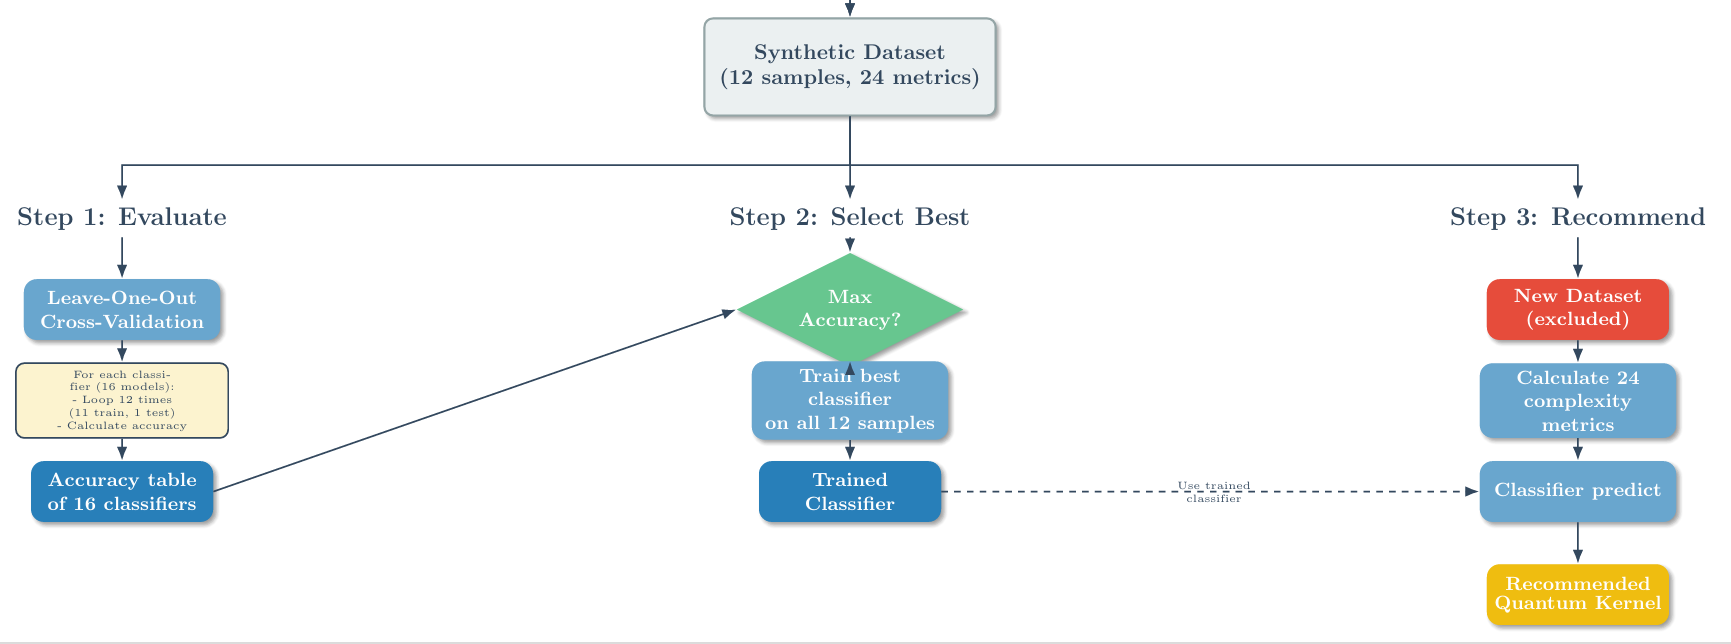

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [41]:
print("="*70)
print("LOAD DATA")
print("="*70)

df = pd.read_csv("synthesis_df.csv", index_col=0)
df_tied = pd.read_csv("task1b_labels.csv")
df_tied = df_tied.set_index('Dataset')

metric_columns = [c for c in df.columns if c != 'Best_Kernel']

print(f"Datasets: {len(df)}")
print(f"Metrics: {len(metric_columns)}")
print(f"Task 1-A samples: {len(df)}")
print(f"Task 1-B samples: {len(df_tied)}")

LOAD DATA
Datasets: 28
Metrics: 24
Task 1-A samples: 28
Task 1-B samples: 95


In [42]:
CLASSIFIERS = {
    'DT': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(n_estimators=10, random_state=42),
    'Ensemble-GB': GradientBoostingClassifier(random_state=42),
    'Ensemble-AB': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(random_state=42), 
        n_estimators=50, 
        random_state=42,
        algorithm='SAMME'
    ),
    'Ensemble-Bg': BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=10,
        random_state=42
    ),
    'SVM-Linear': SVC(kernel='linear', random_state=42),
    'SVM-RBF': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    'SVM-Sigmoid': SVC(kernel='sigmoid', C=1.0, gamma='scale', random_state=42),
    'MLP-500': MLPClassifier(hidden_layer_sizes=(500,), max_iter=1000, random_state=42),
    'MLP-100-100-100': MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=1000, random_state=42),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'NearestCentroid': NearestCentroid(),
    'NaiveBayes': GaussianNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
}

print(f"Classifiers: {len(CLASSIFIERS)}")

Classifiers: 14


In [43]:
def evaluate_task1a(X, y, classifiers, scale_features=True, desc="Task 1-A"):
    """
    Task 1-A: LOOCV với single best kernel
    X: features (single metric hoặc all metrics)
    y: labels (only 1 Best_Kernel)
    """
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    loo = LeaveOneOut()
    results = {}
    
    for clf_name, clf in tqdm(classifiers.items(), desc=desc):
        scores = []
        
        for train_idx, test_idx in loo.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
            
            if scale_features and X.shape[1] > 1:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
            
            try:
                clf_clone = clf.__class__(**clf.get_params())
                clf_clone.fit(X_train, y_train)
                pred = clf_clone.predict(X_test)
                scores.append(1 if pred[0] == y_test[0] else 0)
            except:
                scores.append(0)
        
        results[clf_name] = {
            'accuracy': np.mean(scores),
            'std': np.std(scores),
            'correct': sum(scores),
            'total': len(scores)
        }
    
    return results

def evaluate_task1b(X, df_tied, dataset_names, classifiers, scale_features=True, desc="Task 1-B"):
    """
    Task 1-B: LOOCV với tied best kernels
    Prediction đúng nếu match BẤT KỲ tied kernel nào
    """
    n_datasets = len(dataset_names)
    
    valid_kernels_lookup = {}
    for dataset in dataset_names:
        valid_kernels_lookup[dataset] = df_tied.loc[
            df_tied.index == dataset, 'Best_Kernel'
        ].tolist()
    
    results = {}
    
    for clf_name, clf in tqdm(classifiers.items(), desc=desc):
        scores = []
        
        for test_idx, test_dataset in enumerate(dataset_names):
            X_train_list = []
            y_train_list = []
            
            for train_idx, train_dataset in enumerate(dataset_names):
                if train_dataset == test_dataset:
                    continue
                
                valid_kernels = valid_kernels_lookup[train_dataset]
                for kernel in valid_kernels:
                    X_train_list.append(X[train_idx])
                    y_train_list.append(kernel)
            
            X_train = np.array(X_train_list)
            y_train = np.array(y_train_list)
            
            # Encode
            le = LabelEncoder()
            y_train_encoded = le.fit_transform(y_train)
            
            if len(np.unique(y_train_encoded)) < 2:
                scores.append(0)
                continue
            
            if scale_features and X.shape[1] > 1:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X[test_idx:test_idx+1])
            else:
                X_train_scaled = X_train
                X_test_scaled = X[test_idx:test_idx+1]
            
            valid_kernels_test = valid_kernels_lookup[test_dataset]
            
            try:
                clf_clone = clf.__class__(**clf.get_params())
                clf_clone.fit(X_train_scaled, y_train_encoded)
                pred_encoded = clf_clone.predict(X_test_scaled)
                pred_kernel = le.inverse_transform(pred_encoded)[0]
                
                is_correct = pred_kernel in valid_kernels_test
                scores.append(1 if is_correct else 0)
            except:
                scores.append(0)
        
        results[clf_name] = {
            'accuracy': np.mean(scores),
            'std': np.std(scores),
            'correct': sum(scores),
            'total': n_datasets
        }
    
    return results

In [44]:
dataset_names = df.index.tolist()
y = df['Best_Kernel'].values
X_all = df[metric_columns].values  

all_results = {}

In [45]:
print("\n" + "="*70)
print("CASE 1: SINGLE METRIC - TASK 1-A")
print("="*70)

single_metric_task1a = []

for metric in tqdm(metric_columns, desc="Single Metric Task 1-A"):
    X_single = df[[metric]].values
    results = evaluate_task1a(X_single, y, CLASSIFIERS, scale_features=False, desc="")
    
    for clf_name, res in results.items():
        single_metric_task1a.append({
            'Metric': metric,
            'Classifier': clf_name,
            'Accuracy': res['accuracy'],
            'Correct': res['correct'],
            'Total': res['total']
        })

df_single_1a = pd.DataFrame(single_metric_task1a)
best_single_1a = df_single_1a.loc[df_single_1a['Accuracy'].idxmax()]
print(f"\n★ Best Single Metric (Task 1-A): {best_single_1a['Metric']} + {best_single_1a['Classifier']} = {best_single_1a['Accuracy']:.4f}")

all_results['single_metric_task1a'] = df_single_1a


CASE 1: SINGLE METRIC - TASK 1-A


Single Metric Task 1-A: 100%|██████████| 24/24 [04:46<00:00, 11.95s/it]


★ Best Single Metric (Task 1-A): l2 + RF = 0.6071


In [46]:
print("\n" + "="*70)
print("CASE 2: SINGLE METRIC - TASK 1-B")
print("="*70)

single_metric_task1b = []

for metric in tqdm(metric_columns, desc="Single Metric Task 1-B"):
    X_single = df[[metric]].values
    results = evaluate_task1b(X_single, df_tied, dataset_names, CLASSIFIERS, scale_features=False, desc="")
    
    for clf_name, res in results.items():
        single_metric_task1b.append({
            'Metric': metric,
            'Classifier': clf_name,
            'Accuracy': res['accuracy'],
            'Correct': res['correct'],
            'Total': res['total']
        })

df_single_1b = pd.DataFrame(single_metric_task1b)
best_single_1b = df_single_1b.loc[df_single_1b['Accuracy'].idxmax()]
print(f"\n★ Best Single Metric (Task 1-B): {best_single_1b['Metric']} + {best_single_1b['Classifier']} = {best_single_1b['Accuracy']:.4f}")

all_results['single_metric_task1b'] = df_single_1b


CASE 2: SINGLE METRIC - TASK 1-B


Single Metric Task 1-B: 100%|██████████| 24/24 [05:32<00:00, 13.86s/it]


★ Best Single Metric (Task 1-B): l3 + DT = 0.9286


In [47]:
print("\n" + "="*70)
print("CASE 3: ALL METRICS (24) - TASK 1-A")
print("="*70)

results_all_1a = evaluate_task1a(X_all, y, CLASSIFIERS, scale_features=True, desc="All Metrics Task 1-A")

all_metrics_task1a = []
for clf_name, res in results_all_1a.items():
    all_metrics_task1a.append({
        'Classifier': clf_name,
        'Accuracy': res['accuracy'],
        'Correct': res['correct'],
        'Total': res['total']
    })

df_all_1a = pd.DataFrame(all_metrics_task1a).sort_values('Accuracy', ascending=False)
best_all_1a = df_all_1a.iloc[0]
print(f"\n★ Best All Metrics (Task 1-A): {best_all_1a['Classifier']} = {best_all_1a['Accuracy']:.4f}")

all_results['all_metrics_task1a'] = df_all_1a


CASE 3: ALL METRICS (24) - TASK 1-A


All Metrics Task 1-A: 100%|██████████| 14/14 [00:12<00:00,  1.09it/s]


★ Best All Metrics (Task 1-A): SVM-Linear = 0.5714


In [48]:
print("\n" + "="*70)
print("CASE 4: ALL METRICS (24) - TASK 1-B")
print("="*70)

results_all_1b = evaluate_task1b(X_all, df_tied, dataset_names, CLASSIFIERS, scale_features=True, desc="All Metrics Task 1-B")

all_metrics_task1b = []
for clf_name, res in results_all_1b.items():
    all_metrics_task1b.append({
        'Classifier': clf_name,
        'Accuracy': res['accuracy'],
        'Correct': res['correct'],
        'Total': res['total']
    })

df_all_1b = pd.DataFrame(all_metrics_task1b).sort_values('Accuracy', ascending=False)
best_all_1b = df_all_1b.iloc[0]
print(f"\n★ Best All Metrics (Task 1-B): {best_all_1b['Classifier']} = {best_all_1b['Accuracy']:.4f}")

all_results['all_metrics_task1b'] = df_all_1b


CASE 4: ALL METRICS (24) - TASK 1-B


All Metrics Task 1-B: 100%|██████████| 14/14 [00:14<00:00,  1.00s/it]


★ Best All Metrics (Task 1-B): SVM-RBF = 0.9286


In [49]:
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

summary_data = [
    {
        'Case': 'Single Metric',
        'Task': 'Task 1-A',
        'Best_Config': f"{best_single_1a['Metric']} + {best_single_1a['Classifier']}",
        'Accuracy': best_single_1a['Accuracy']
    },
    {
        'Case': 'Single Metric',
        'Task': 'Task 1-B',
        'Best_Config': f"{best_single_1b['Metric']} + {best_single_1b['Classifier']}",
        'Accuracy': best_single_1b['Accuracy']
    },
    {
        'Case': 'All Metrics (24)',
        'Task': 'Task 1-A',
        'Best_Config': best_all_1a['Classifier'],
        'Accuracy': best_all_1a['Accuracy']
    },
    {
        'Case': 'All Metrics (24)',
        'Task': 'Task 1-B',
        'Best_Config': best_all_1b['Classifier'],
        'Accuracy': best_all_1b['Accuracy']
    },
]

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

print("\n" + "-"*70)
print("PIVOT TABLE:")
print("-"*70)
pivot = summary_df.pivot(index='Case', columns='Task', values='Accuracy')
print(pivot)



SUMMARY

            Case     Task Best_Config  Accuracy
   Single Metric Task 1-A     l2 + RF  0.607143
   Single Metric Task 1-B     l3 + DT  0.928571
All Metrics (24) Task 1-A  SVM-Linear  0.571429
All Metrics (24) Task 1-B     SVM-RBF  0.928571

----------------------------------------------------------------------
PIVOT TABLE:
----------------------------------------------------------------------
Task              Task 1-A  Task 1-B
Case                                
All Metrics (24)  0.571429  0.928571
Single Metric     0.607143  0.928571


In [50]:
def train_task1b_models():
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_all)
    
    X_train_single, X_train_all, y_train_list = [], [], []
    
    for idx, ds_name in enumerate(dataset_names):
        valid_kernels = df_tied.loc[df_tied.index == ds_name, 'Best_Kernel'].tolist()
        for kernel in valid_kernels:
            X_train_single.append([df.loc[ds_name, 'n4']])
            X_train_all.append(X_scaled[idx])
            y_train_list.append(kernel)
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_train_list)
    
    # Model 1: n4 + DT
    model_single = DecisionTreeClassifier(random_state=42)
    model_single.fit(np.array(X_train_single), y_encoded)
    
    # Model 2: All + SVM-RBF  
    model_all = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
    model_all.fit(np.array(X_train_all), y_encoded)
    
    return {
        'single': {'model': model_single, 'feature': 'n4'},
        'all': {'model': model_all, 'scaler': scaler},
        'encoder': le
    }

print("="*70)
print("TRAIN TASK 1-B MODELS")
print("="*70)
trained_models = train_task1b_models()

TRAIN TASK 1-B MODELS


In [51]:
import sys
from pathlib import Path
qml_path = (Path.cwd() / "../../QML").resolve()
sys.path.insert(0, str(qml_path))

from Qsun.Qkernels import *
from Qsun.Qgates import *
from Qsun.Qmeas import *
from Qsun.Qcircuit import *
from Qsun.Qwave import *
from Qsun.Qencodes import *
from Qsun.Qdata import *

import numpy as np
import matplotlib.pyplot as plt
from src.load_datasets import *
from src.kernel_evaluation import *
from tqdm import tqdm
import problexity as px
from sklearn.datasets import load_digits, make_moons, make_circles, make_classification
np.random.seed(1234)

In [52]:
def prepare_dataset(X, y, name, max_features=4):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    
    if X_scaled.shape[1] > max_features:
        pca = PCA(n_components=max_features)
        X_scaled = pca.fit_transform(X_scaled)
        print(f"  {name}: {X.shape} → PCA → {X_scaled.shape} ({pca.explained_variance_ratio_.sum():.1%} var)")
    else:
        print(f"  {name}: {X_scaled.shape}")
    
    return X_scaled, y

digits = load_digits()
mask = (digits.target == 0) | (digits.target == 1)
X_digits, y_digits = prepare_dataset(digits.data[mask], digits.target[mask], "Digits_0v1")

X_moons, y_moons = make_moons(n_samples=200, noise=0.35, random_state=42)
X_moons, y_moons = prepare_dataset(X_moons, y_moons, "Moons_n35")

X_circles, y_circles = make_circles(n_samples=200, noise=0.1, factor=0.5, random_state=42)
X_circles, y_circles = prepare_dataset(X_circles, y_circles, "Circles")

X_synth, y_synth = make_classification(
    n_samples=200, n_features=4, n_informative=3, 
    n_redundant=1, flip_y=0.1, random_state=42
)
X_synth, y_synth = prepare_dataset(X_synth, y_synth, "Synthetic")

test_datasets = {
    'Digits_0v1': (X_digits, y_digits),
    'Moons_n35': (X_moons, y_moons),
    'Circles': (X_circles, y_circles),
    'Synthetic': (X_synth, y_synth)
}

  Digits_0v1: (360, 64) → PCA → (360, 4) (71.6% var)
  Moons_n35: (200, 2)
  Circles: (200, 2)
  Synthetic: (200, 4)


In [53]:
print("\n" + "="*70)
print("COMPUTE COMPLEXITY METRICS FOR TEST DATASETS")
print("="*70)

complexities_test = {}

for name, (X, y) in test_datasets.items():
    print(f"\n📊 {name}: shape={X.shape}")
    
    complexities_runs = []
    for i in range(10):
        cc = px.ComplexityCalculator()
        cc.fit(X, y)
        results = list(cc.complexity)
        results.append(kolmogorov_complex(X)['best_bytes'])
        results.append(intrinsic_dim_from_cov(X))
        complexities_runs.append(results)
    
    complexities_runs = np.array(complexities_runs)
    complexities_test[name] = np.mean(complexities_runs, axis=0)
    print(f"   Computed 24 metrics")

df_test = pd.DataFrame(complexities_test, index=metric_columns).T
print(f"\n✓ Test datasets: {len(df_test)}")


COMPUTE COMPLEXITY METRICS FOR TEST DATASETS

📊 Digits_0v1: shape=(360, 4)
   Computed 24 metrics

📊 Moons_n35: shape=(200, 2)
   Computed 24 metrics

📊 Circles: shape=(200, 2)
   Computed 24 metrics

📊 Synthetic: shape=(200, 4)
   Computed 24 metrics

✓ Test datasets: 4


In [54]:
print("\n" + "="*70)
print("KERNEL RECOMMENDATIONS")
print("="*70)

recommendations = []

for ds_name in df_test.index:
    metrics = df_test.loc[ds_name]
    
    n4_value = metrics['n4']
    X_single = np.array([[n4_value]])
    pred_single = trained_models['single']['model'].predict(X_single)
    kernel_single = trained_models['encoder'].inverse_transform(pred_single)[0]

    X_all_test = metrics[metric_columns].values.reshape(1, -1)
    X_all_scaled = trained_models['all']['scaler'].transform(X_all_test)
    pred_all = trained_models['all']['model'].predict(X_all_scaled)
    kernel_all = trained_models['encoder'].inverse_transform(pred_all)[0]

    proba = trained_models['all']['model'].predict_proba(X_all_scaled)[0]
    top3 = sorted(zip(trained_models['encoder'].classes_, proba), 
                  key=lambda x: x[1], reverse=True)[:3]
    
    recommendations.append({
        'Dataset': ds_name,
        'n4': n4_value,
        'Single(n4+DT)': kernel_single,
        'All(SVM-RBF)': kernel_all,
        'Top3': top3
    })
    
    print(f"\n {ds_name}:")
    print(f"   n4 = {n4_value:.4f}")
    print(f"   Single (n4+DT): {kernel_single}")
    print(f"   All (SVM-RBF):  {kernel_all}")
    print(f"   Top-3: {[(k, f'{p:.3f}') for k, p in top3]}")


KERNEL RECOMMENDATIONS

 Digits_0v1:
   n4 = 0.0003
   Single (n4+DT): HZY_CZ
   All (SVM-RBF):  HighDim
   Top-3: [(np.str_('SeparableRX'), '0.212'), (np.str_('ZFeatureMap'), '0.210'), (np.str_('HZY_CZ'), '0.206')]

 Moons_n35:
   n4 = 0.1460
   Single (n4+DT): HZY_CZ
   All (SVM-RBF):  HighDim
   Top-3: [(np.str_('SeparableRX'), '0.254'), (np.str_('HZY_CZ'), '0.233'), (np.str_('HighDim'), '0.159')]

 Circles:
   n4 = 0.1835
   Single (n4+DT): HardwareEfficientRx
   All (SVM-RBF):  HardwareEfficientRx
   Top-3: [(np.str_('HighDim'), '0.287'), (np.str_('HZY_CZ'), '0.223'), (np.str_('ZFeatureMap'), '0.151')]

 Synthetic:
   n4 = 0.0840
   Single (n4+DT): HighDim
   All (SVM-RBF):  HighDim
   Top-3: [(np.str_('SeparableRX'), '0.248'), (np.str_('HZY_CZ'), '0.223'), (np.str_('HighDim'), '0.179')]


In [55]:
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

summary_df = pd.DataFrame([{
    'Dataset': r['Dataset'],
    'n4': f"{r['n4']:.4f}",
    'Single(n4+DT)': r['Single(n4+DT)'],
    'All(SVM-RBF)': r['All(SVM-RBF)'],
    'Match': 'True' if r['Single(n4+DT)'] == r['All(SVM-RBF)'] else 'False'
} for r in recommendations])

print("\n" + summary_df.to_string(index=False))



SUMMARY

   Dataset     n4       Single(n4+DT)        All(SVM-RBF) Match
Digits_0v1 0.0003              HZY_CZ             HighDim False
 Moons_n35 0.1460              HZY_CZ             HighDim False
   Circles 0.1835 HardwareEfficientRx HardwareEfficientRx  True
 Synthetic 0.0840             HighDim             HighDim  True


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

print("\n" + "="*70)
print("VERIFY: QUANTUM KERNEL ACCURACY")
print("="*70)

verification_results = []

for rec in recommendations:
    ds_name = rec['Dataset']
    X, y = test_datasets[ds_name]
    
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    scaler_pi = MinMaxScaler(feature_range=(0, np.pi))
    X_tr_pi = scaler_pi.fit_transform(X_tr)
    X_te_pi = scaler_pi.transform(X_te)
    
    print(f"\n {ds_name}: train={len(X_tr)}, test={len(X_te)}")
    
    # Lấy unique kernels được recommend
    kernels_to_test = list(set([rec['Single(n4+DT)'], rec['All(SVM-RBF)']]))
    
    for kernel_name in kernels_to_test:
        print(f"   Testing {kernel_name}...", end=" ")
        
        try:
            K_train, K_test = kernel_matrix(X_tr_pi, X_te_pi, kernel_name, n_layers=2)
            
            result = evaluate_kernel(K_train, K_test, y_tr, y_te, kernel_name, "SVM")
            
            print(f"Train={result.train_accuracy:.4f}, Test={result.test_accuracy:.4f}")
            
            verification_results.append({
                'Dataset': ds_name,
                'Kernel': kernel_name,
                'Train_Acc': result.train_accuracy,
                'Test_Acc': result.test_accuracy,
                'Recommended_By': 'Both' if rec['Single(n4+DT)'] == rec['All(SVM-RBF)'] == kernel_name 
                                  else ('Single metric' if kernel_name == rec['Single(n4+DT)'] else 'All metrics')
            })
        except Exception as e:
            print(f"Error: {e}")


VERIFY: QUANTUM KERNEL ACCURACY

 Digits_0v1: train=288, test=72
   Testing HighDim... Train=1.0000, Test=1.0000
   Testing HZY_CZ... Train=1.0000, Test=1.0000

 Moons_n35: train=160, test=40
   Testing HighDim... Train=0.8688, Test=0.8750
   Testing HZY_CZ... Train=0.8125, Test=0.8000

 Circles: train=160, test=40
   Testing HardwareEfficientRx... Train=0.9812, Test=1.0000

 Synthetic: train=160, test=40
   Testing HighDim... Train=0.9062, Test=0.8500


In [57]:
print("\n" + "="*70)
print("VERIFICATION RESULTS")
print("="*70)

df_verify = pd.DataFrame(verification_results)
print("\n" + df_verify.to_string(index=False))

print("\n" + "="*70)
print("TEST ALL KERNELS FOR COMPARISON")
print("="*70)

all_kernel_results = []

for ds_name in df_test.index:
    X, y = test_datasets[ds_name]
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale về (0, π) cho quantum kernel
    scaler_pi = MinMaxScaler(feature_range=(0, np.pi))
    X_tr_pi = scaler_pi.fit_transform(X_tr)
    X_te_pi = scaler_pi.transform(X_te)
    
    print(f"\n {ds_name}:")
    
    for kernel_name in ENCODING_REGISTER.keys():
        try:
            K_train, K_test = kernel_matrix(X_tr_pi, X_te_pi, kernel_name, n_layers=2)
            result = evaluate_kernel(K_train, K_test, y_tr, y_te, kernel_name, "SVM")
            
            all_kernel_results.append({
                'Dataset': ds_name,
                'Kernel': kernel_name,
                'Test_Acc': result.test_accuracy
            })
            print(f"   {kernel_name}: {result.test_accuracy:.4f}")
        except Exception as e:
            print(f"   {kernel_name}: Error")


VERIFICATION RESULTS

   Dataset              Kernel  Train_Acc  Test_Acc Recommended_By
Digits_0v1             HighDim    1.00000     1.000    All metrics
Digits_0v1              HZY_CZ    1.00000     1.000  Single metric
 Moons_n35             HighDim    0.86875     0.875    All metrics
 Moons_n35              HZY_CZ    0.81250     0.800  Single metric
   Circles HardwareEfficientRx    0.98125     1.000           Both
 Synthetic             HighDim    0.90625     0.850           Both

TEST ALL KERNELS FOR COMPARISON

 Digits_0v1:
   YZ_CX: 0.5417
   HighDim: 1.0000
   HZY_CZ: 0.9861
   Chebyshev: 0.5417
   ParamZFeatureMap: 0.7361
   SeparableRX: 1.0000
   HardwareEfficientRx: 1.0000
   ZFeatureMap: 0.9306
   ZZFeatureMap: 0.8333

 Moons_n35:
   YZ_CX: 0.5250
   HighDim: 0.8750
   HZY_CZ: 0.8000
   Chebyshev: 0.4500
   ParamZFeatureMap: 0.6750
   SeparableRX: 0.8000
   HardwareEfficientRx: 0.8250
   ZFeatureMap: 0.6000
   ZZFeatureMap: 0.6250

 Circles:
   YZ_CX: 0.5500
   HighDim: 

In [58]:
print("\n" + "="*70)
print("RECOMMENDATION ACCURACY")
print("="*70)

df_all_kernels = pd.DataFrame(all_kernel_results)

comparison_table = []
for ds_name in df_test.index:
    rec = next(r for r in recommendations if r['Dataset'] == ds_name)
    ds_results = df_all_kernels[df_all_kernels['Dataset'] == ds_name]
    
    if len(ds_results) > 0:
        actual_best = ds_results.loc[ds_results['Test_Acc'].idxmax()]
        
        rec_single = ds_results[ds_results['Kernel'] == rec['Single(n4+DT)']]
        rec_all = ds_results[ds_results['Kernel'] == rec['All(SVM-RBF)']]
        
        single_acc = rec_single['Test_Acc'].values[0] if len(rec_single) > 0 else None
        all_acc = rec_all['Test_Acc'].values[0] if len(rec_all) > 0 else None
        
        comparison_table.append({
            'Dataset': ds_name,
            'Actual_Best': actual_best['Kernel'],
            'Best_Acc': f"{actual_best['Test_Acc']:.4f}",
            'Rec_Single': rec['Single(n4+DT)'],
            'Single_Acc': f"{single_acc:.4f}" if single_acc else "N/A",
            'Rec_All': rec['All(SVM-RBF)'],
            'All_Acc': f"{all_acc:.4f}" if all_acc else "N/A",
        })

df_comparison = pd.DataFrame(comparison_table)
print("\n" + df_comparison.to_string(index=False))


RECOMMENDATION ACCURACY

   Dataset Actual_Best Best_Acc          Rec_Single Single_Acc             Rec_All All_Acc
Digits_0v1     HighDim   1.0000              HZY_CZ     0.9861             HighDim  1.0000
 Moons_n35     HighDim   0.8750              HZY_CZ     0.8000             HighDim  0.8750
   Circles SeparableRX   1.0000 HardwareEfficientRx     1.0000 HardwareEfficientRx  1.0000
 Synthetic ZFeatureMap   0.9250             HighDim     0.8500             HighDim  0.8500


In [59]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

n_runs = 10
all_run_results = []

print("="*70)
print(f"VERIFY WITH MULTIPLE RUNS (n_runs={n_runs})")
print("="*70)

for ds_name in df_test.index:
    X, y = test_datasets[ds_name]
    print(f"\n {ds_name}:")
    
    kernel_scores = {k: [] for k in ENCODING_REGISTER.keys()}
    
    for run in range(n_runs):
        seed = 42 + run
        
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=0.2, random_state=seed, stratify=y
        )
        
        scaler_pi = MinMaxScaler(feature_range=(0, np.pi))
        X_tr_pi = scaler_pi.fit_transform(X_tr)
        X_te_pi = scaler_pi.transform(X_te)
        
        for kernel_name in ENCODING_REGISTER.keys():
            try:
                K_train, K_test = kernel_matrix(X_tr_pi, X_te_pi, kernel_name, n_layers=2)
                result = evaluate_kernel(K_train, K_test, y_tr, y_te, kernel_name, "SVM")
                kernel_scores[kernel_name].append(result.test_accuracy)
            except:
                pass
    
    for kernel_name, scores in kernel_scores.items():
        if len(scores) > 0:
            mean_acc = np.mean(scores)
            std_acc = np.std(scores)
            print(f"   {kernel_name}: {mean_acc:.4f} ± {std_acc:.4f}")
            
            all_run_results.append({
                'Dataset': ds_name,
                'Kernel': kernel_name,
                'Mean_Acc': mean_acc,
                'Std_Acc': std_acc,
                'n_runs': len(scores)
            })

VERIFY WITH MULTIPLE RUNS (n_runs=10)

 Digits_0v1:
   YZ_CX: 0.4889 ± 0.0447
   HighDim: 1.0000 ± 0.0000
   HZY_CZ: 0.9944 ± 0.0092
   Chebyshev: 0.5500 ± 0.0616
   ParamZFeatureMap: 0.7528 ± 0.0438
   SeparableRX: 0.9986 ± 0.0042
   HardwareEfficientRx: 1.0000 ± 0.0000
   ZFeatureMap: 0.9722 ± 0.0215
   ZZFeatureMap: 0.8972 ± 0.0418

 Moons_n35:
   YZ_CX: 0.5450 ± 0.0630
   HighDim: 0.8575 ± 0.0488
   HZY_CZ: 0.7975 ± 0.0530
   Chebyshev: 0.5100 ± 0.0436
   ParamZFeatureMap: 0.5650 ± 0.0339
   SeparableRX: 0.7750 ± 0.0698
   HardwareEfficientRx: 0.7875 ± 0.0700
   ZFeatureMap: 0.6600 ± 0.0572
   ZZFeatureMap: 0.6500 ± 0.0570

 Circles:
   YZ_CX: 0.4900 ± 0.0604
   HighDim: 0.9475 ± 0.0344
   HZY_CZ: 0.9700 ± 0.0367
   Chebyshev: 0.5600 ± 0.0604
   ParamZFeatureMap: 0.5375 ± 0.0584
   SeparableRX: 0.9875 ± 0.0168
   HardwareEfficientRx: 0.9875 ± 0.0168
   ZFeatureMap: 0.9850 ± 0.0166
   ZZFeatureMap: 0.8275 ± 0.0617

 Synthetic:
   YZ_CX: 0.5100 ± 0.0421
   HighDim: 0.8475 ± 0.0439
  

In [60]:
print("\n" + "="*70)
print(f"COMPARISON WITH MULTIPLE RUNS: (n_runs={n_runs})")
print("="*70)

df_runs = pd.DataFrame(all_run_results)

for ds_name in df_test.index:
    rec = next(r for r in recommendations if r['Dataset'] == ds_name)
    ds_results = df_runs[df_runs['Dataset'] == ds_name].copy()
    
    if len(ds_results) > 0:
        best_idx = ds_results['Mean_Acc'].idxmax()
        actual_best = ds_results.loc[best_idx]
        
        rec_single_row = ds_results[ds_results['Kernel'] == rec['Single(n4+DT)']]
        rec_all_row = ds_results[ds_results['Kernel'] == rec['All(SVM-RBF)']]
        
        print(f"\n{ds_name}:")
        print(f"   Actual Best: {actual_best['Kernel']} = {actual_best['Mean_Acc']:.4f} ± {actual_best['Std_Acc']:.4f}")
        
        if len(rec_single_row) > 0:
            r = rec_single_row.iloc[0]
            gap = actual_best['Mean_Acc'] - r['Mean_Acc']
            print(f"   Rec Single:  {rec['Single(n4+DT)']} = {r['Mean_Acc']:.4f} ± {r['Std_Acc']:.4f} (gap: {gap:.4f})")
        
        if len(rec_all_row) > 0:
            r = rec_all_row.iloc[0]
            gap = actual_best['Mean_Acc'] - r['Mean_Acc']
            print(f"   Rec All:     {rec['All(SVM-RBF)']} = {r['Mean_Acc']:.4f} ± {r['Std_Acc']:.4f} (gap: {gap:.4f})")



COMPARISON WITH MULTIPLE RUNS: (n_runs=10)

Digits_0v1:
   Actual Best: HighDim = 1.0000 ± 0.0000
   Rec Single:  HZY_CZ = 0.9944 ± 0.0092 (gap: 0.0056)
   Rec All:     HighDim = 1.0000 ± 0.0000 (gap: 0.0000)

Moons_n35:
   Actual Best: HighDim = 0.8575 ± 0.0488
   Rec Single:  HZY_CZ = 0.7975 ± 0.0530 (gap: 0.0600)
   Rec All:     HighDim = 0.8575 ± 0.0488 (gap: 0.0000)

Circles:
   Actual Best: SeparableRX = 0.9875 ± 0.0168
   Rec Single:  HardwareEfficientRx = 0.9875 ± 0.0168 (gap: 0.0000)
   Rec All:     HardwareEfficientRx = 0.9875 ± 0.0168 (gap: 0.0000)

Synthetic:
   Actual Best: SeparableRX = 0.8625 ± 0.0491
   Rec Single:  HighDim = 0.8475 ± 0.0439 (gap: 0.0150)
   Rec All:     HighDim = 0.8475 ± 0.0439 (gap: 0.0150)


In [63]:
print("\n" + "="*70)
print("FULL RESULTS TABLE (Mean ± Std over 10 runs)")
print("="*70)

pivot = df_runs.pivot(index='Kernel', columns='Dataset', values='Mean_Acc')
pivot_std = df_runs.pivot(index='Kernel', columns='Dataset', values='Std_Acc')

print("\nMean Accuracy:")
print(pivot.round(4).to_string())

print("\nStd Deviation:")
print(pivot_std.round(4).to_string())


FULL RESULTS TABLE (Mean ± Std over 10 runs)

Mean Accuracy:
Dataset              Circles  Digits_0v1  Moons_n35  Synthetic
Kernel                                                        
Chebyshev             0.5600      0.5500     0.5100     0.5100
HZY_CZ                0.9700      0.9944     0.7975     0.8500
HardwareEfficientRx   0.9875      1.0000     0.7875     0.8625
HighDim               0.9475      1.0000     0.8575     0.8475
ParamZFeatureMap      0.5375      0.7528     0.5650     0.6025
SeparableRX           0.9875      0.9986     0.7750     0.8625
YZ_CX                 0.4900      0.4889     0.5450     0.5100
ZFeatureMap           0.9850      0.9722     0.6600     0.8500
ZZFeatureMap          0.8275      0.8972     0.6500     0.7975

Std Deviation:
Dataset              Circles  Digits_0v1  Moons_n35  Synthetic
Kernel                                                        
Chebyshev             0.0604      0.0616     0.0436     0.0875
HZY_CZ                0.0367      0.0092